## Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

### Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

### Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

# 1. Preparation

<div class="alert alert-block alert-info">
<b>Improve: </b> Please collect all imports in the first cell.
</div>

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [3]:
print('Start Date:', data.idxmin())
print('End Date;', data.idxmax())

Start Date: num_orders   2018-04-06 06:00:00
dtype: datetime64[ns]
End Date; num_orders   2018-08-20 02:00:00
dtype: datetime64[ns]


I opened the data set and set the parsed the date time column and set it as the index to help with analysis. I then resampled it by one hour using .resample().sum() to get the total number of orders for each hour. I printed the first five rows and the data frame information to verify my code worked.

# 2. Analysis

## Rolling Mean and Standard Deviation

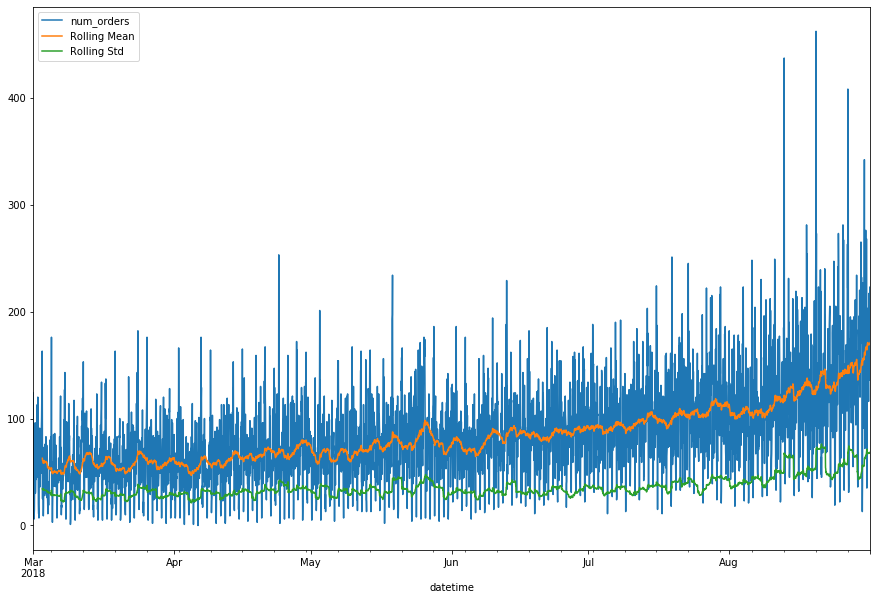

In [4]:
data['Rolling Mean'] = data['num_orders'].rolling(50).mean()
data['Rolling Std'] = data['num_orders'].rolling(50).std()
data.plot(figsize=(15, 10))

I ploted the data, rolling mean, and standard deviation. You can see that there is an upward trend in numbers of order per hour showing that the amount of orders is greater in the summer than in the spring.

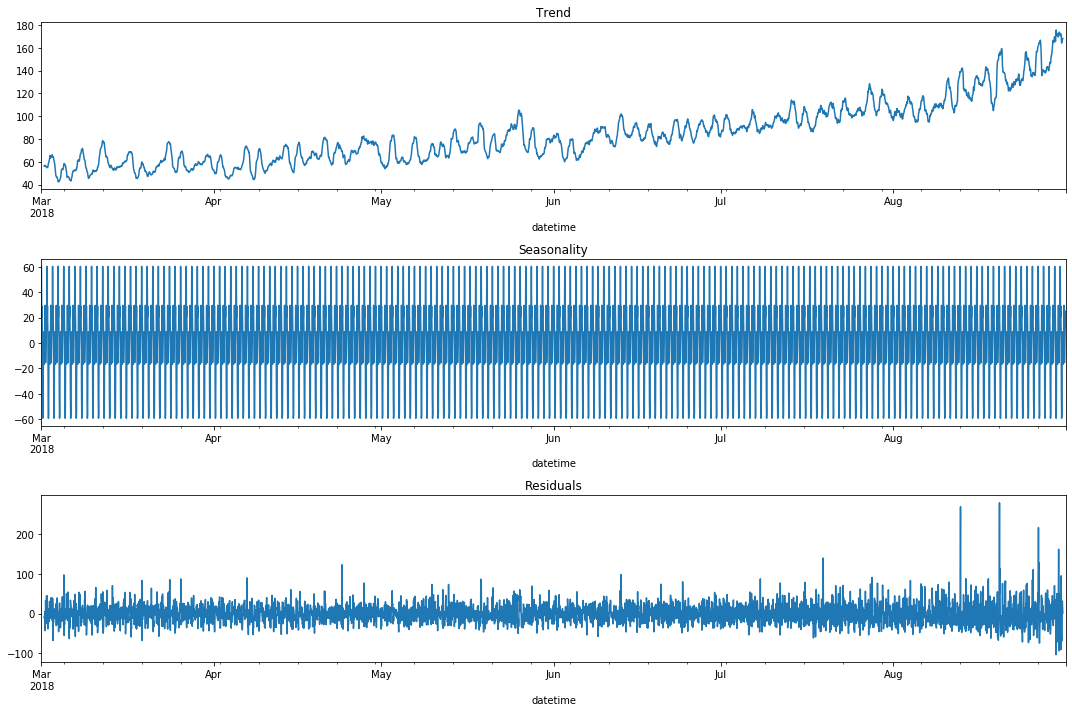

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomposed = seasonal_decompose(data['num_orders'])

plt.figure(figsize=(15, 10))
plt.subplot(311)
# To display the graph correctly, specify its
# axes ax equal to plt.gca() (gca = get current axis)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

I decompsed the data and found that there is seasonality in the data however the graph is very tight and we cannot make a conclusion as to what is seasonal.

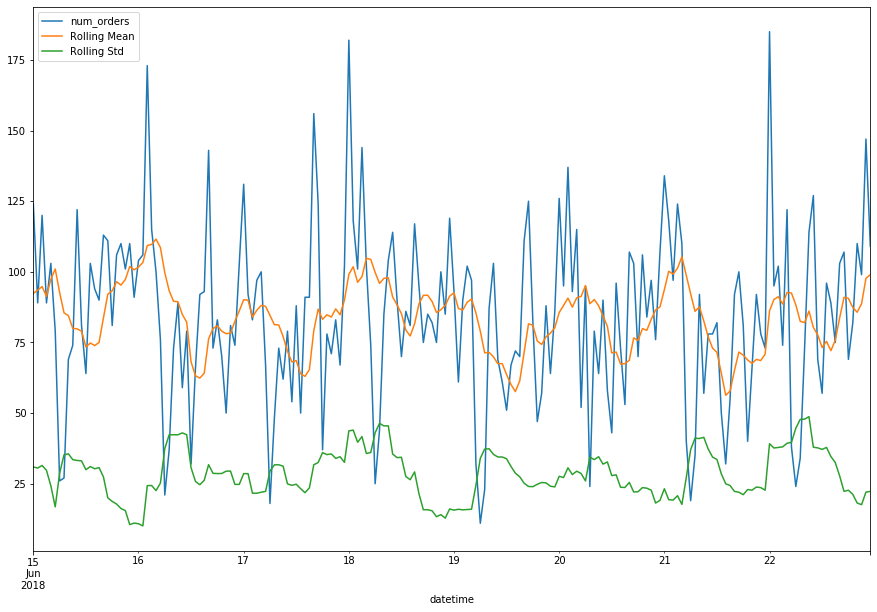

In [6]:
one_week = data['2018-06-15':'2018-06-22'].copy()
one_week['Rolling Mean'] = data['num_orders'].rolling(10).mean()
one_week['Rolling Std'] = data['num_orders'].rolling(10).std()
one_week.plot(figsize=(15, 10))

I pulled a seven day sample from the data about midway through the values. You can see that the data is alot more stationary than the total dataset. 

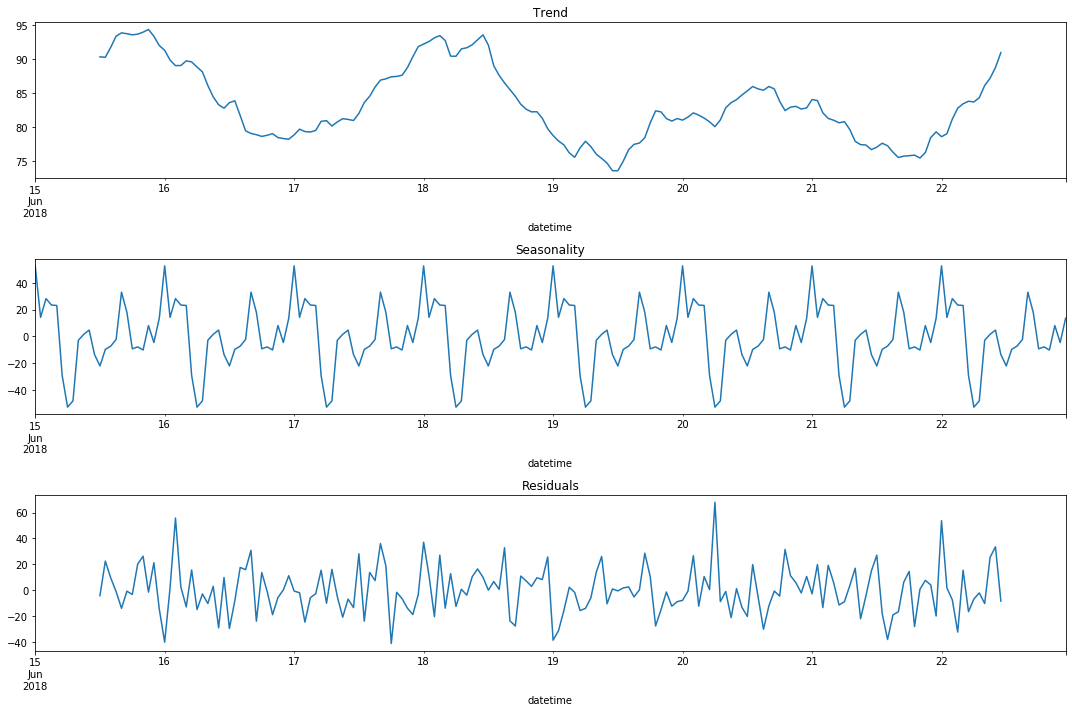

In [7]:
one_week_decomposed = seasonal_decompose(one_week['num_orders'])
plt.figure(figsize=(15, 10))
plt.subplot(311)
one_week_decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
one_week_decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
one_week_decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In the seasonal plot you can see that the seasonality is due to a rise and fall in orders throughout the day.

# 3. Training

## Feature Prep

In [8]:
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day    

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
make_features(data, 20)
data.head()

,num_orders,Rolling Mean,Rolling Std,year,month,day,lag_1,lag_2,lag_3,lag_4,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,2018,3,1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,2018,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2018,3,1,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,2018,3,1,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,2018,3,1,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I used the index to create the dte time features and used a for loop and the shift method to create the lag features. The data is all numerical and there fore does not need encoding.

In [9]:
from sklearn.model_selection import train_test_split


train, test = train_test_split(data, shuffle=False, test_size=0.2)
train = train.dropna()
print(train.shape)
print(test.shape)

(3483, 26)
(884, 26)


In [10]:
valid, test = train_test_split(test, shuffle=False, test_size=0.5)
train = train.dropna()
print(train.shape)
print(valid.shape)
print(test.shape)

(3483, 26)
(442, 26)
(442, 26)


In [11]:
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']
valid_features = valid.drop(['num_orders'], axis=1)
valid_target = valid['num_orders']
test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

I split the data set into a train and test set then I further split the test data into a validation and test set that i can use to test the models then i defined printed the shapes to verify the split was done correctly and i verified the features.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from math import sqrt

linreg = LinearRegression()
linreg.fit(train_features, train_target)
linreg_valid_predict = linreg.predict(valid_features)
print(sqrt(mean_squared_error(valid_target, linreg_valid_predict)))

36.920282339915325


I did a simple linear regression model and got a RMSE of 39

In [13]:
from sklearn.ensemble import RandomForestRegressor

rf_base_model = RandomForestRegressor(n_estimators=10, random_state=12345)
rf_base_model.fit(train_features, train_target)
rf_base_valid_predict = rf_base_model.predict(valid_features)
print(sqrt(mean_squared_error(valid_target, rf_base_valid_predict)))

35.88100652098929


I trained a base model Random Forest Regressor to get a starter RMSE to see if i can improve it.

In [14]:
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]}

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit()

grid_rf_model = RandomForestRegressor(random_state=12345)
rf_grid =  GridSearchCV(estimator = grid_rf_model, param_grid = param_grid, cv = tscv, verbose = 2, n_jobs = -1)
rf_grid.fit(train_features, train_target)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:784: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.4s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 19.8min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn..._jobs=None,
                                             oob_score=False,
                                             random_state=12345, verbose=0,
                                             warm_sta

In [16]:
print(rf_grid.best_params_)

{'bootstrap': True, 'max_depth': 80, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1000}


In [26]:
rf_model = RandomForestRegressor(bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000, random_state=12345)
rf_model.fit(train_features, train_target)
rf_valid_predict = rf_model.predict(valid_features)
print(sqrt(mean_squared_error(valid_target, rf_valid_predict)))


22.076356947472057


I used Grid Search CV to tune hyperparameters and it improved the RMSE from 41 to 38.

In [18]:
import lightgbm as lgb

lgb_train_data = lgb.Dataset(train_features, label=train_target)
params = {}
params['boosting_type'] = 'gbdt'
params['metric'] = 'mse'
params['num_leaves'] = 1000
params['min_data'] = 50
params['max_depth'] = 10
params['task'] = 'predict'


lgb_model_1 = lgb.train(params, lgb_train_data, 100)
lgb_1_valid_pred = lgb_model_1.predict(valid_features)
print(sqrt(mean_squared_error(valid_target, lgb_1_valid_pred)))

34.682318664811135


In [19]:
lgb_train_data = lgb.Dataset(train_features, label=train_target)
params_2 = {}
params['boosting_type'] = 'gbdt'
params['metric'] = 'mse'
params['num_leaves'] = 3000
params['min_data'] = 10
params['max_depth'] = 10
params['task'] = 'predict'


lgb_model_2 = lgb.train(params_2, lgb_train_data, 1000)
lgb_2_valid_pred = lgb_model_2.predict(valid_features)
print(sqrt(mean_squared_error(valid_target, lgb_2_valid_pred)))

33.898113389928746


I trained a couple of gradient boosting models to see if the would preform better than the random forest regressor. The RMSE was slightly better.

# 4. Testing

In [20]:
train_features = pd.concat([train_features, valid_features], axis=0)
train_target = pd.concat([train_target, valid_target], axis=0)
train_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3925 entries, 2018-03-03 01:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 25 columns):
Rolling Mean    3925 non-null float64
Rolling Std     3925 non-null float64
year            3925 non-null int64
month           3925 non-null int64
day             3925 non-null int64
lag_1           3925 non-null float64
lag_2           3925 non-null float64
lag_3           3925 non-null float64
lag_4           3925 non-null float64
lag_5           3925 non-null float64
lag_6           3925 non-null float64
lag_7           3925 non-null float64
lag_8           3925 non-null float64
lag_9           3925 non-null float64
lag_10          3925 non-null float64
lag_11          3925 non-null float64
lag_12          3925 non-null float64
lag_13          3925 non-null float64
lag_14          3925 non-null float64
lag_15          3925 non-null float64
lag_16          3925 non-null float64
lag_17          3925 non-null float64
lag_18          392

I combined the tran set and validation set to retrain the models before final testing. This will add more training to result in a better score

In [21]:
linreg.fit(train_features, train_target)
linreg_test_predict = linreg.predict(test_features)
print(sqrt(mean_squared_error(test_target, linreg_test_predict)))

46.48676762135294


In [27]:
rf_model.fit(train_features, train_target)
rf_test_predict = rf_model.predict(test_features)
print(sqrt(mean_squared_error(test_target, rf_test_predict)))

50.19193432827929


In [28]:
lgb_train_data = lgb.Dataset(train_features, label=train_target)
lgb_model_1 = lgb.train(params, lgb_train_data, 100)
lgb_1_test_pred = lgb_model_1.predict(test_features)
print(sqrt(mean_squared_error(test_target, lgb_1_test_pred)))

48.25176917245794


In [29]:
lgb_train_data = lgb.Dataset(train_features, label=train_target)
lgb_model_2 = lgb.train(params_2, lgb_train_data, 1000)
lgb_2_test_pred = lgb_model_2.predict(test_features)
print(sqrt(mean_squared_error(test_target, lgb_2_test_pred)))

48.916746944610864


I did final testing and it shows that the simple linear regression model is the onle one that achieves the RMSE requirements. This is good because the model is also the fastest model and will be able to make the prediction quickly.